In [ ]:
import numpy as np
import itertools
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
from multiprocessing import get_context
from typing import Optional, Tuple, List
from path_helpers import process_edge
from IPython.display import Image, display

def create_animation(steps: List[List[int]], points: np.ndarray, filename: str = 'path_building_parallel.gif'):
    """Create animation of path building process."""
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title("Building the Best Hamiltonian Path Step-by-Step")
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")
    ax.grid(True)
    ax.set_aspect('equal')

    ax.scatter(points[:, 0], points[:, 1], color='blue', zorder=2)
    for idx, (x, y) in enumerate(points):
        ax.text(x + 0.01, y + 0.01, str(idx), fontsize=12)

    line, = ax.plot([], [], 'o-', color='red', markersize=8, zorder=1)

    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        current_path = steps[i]
        path_points = points[list(current_path)]
        line.set_data(path_points[:, 0], path_points[:, 1])
        ax.set_title(f"Step {i}: Building the Path")
        return line,

    ani = animation.FuncAnimation(fig, animate, init_func=init,
                                frames=len(steps), interval=1000, blit=True)
    ani.save(filename, writer='pillow')
    plt.close()
    print(f"Animation saved as {filename}")

def solve_hamiltonian_path_dp(distance_matrix: np.ndarray) -> Tuple[Optional[List[int]], float]:
    """
    Solve the Hamiltonian Path problem using dynamic programming.
    Time complexity: O(n^2 * 2^n)
    Space complexity: O(n * 2^n)
    
    Args:
        distance_matrix: n x n matrix of distances between points
        
    Returns:
        tuple: (optimal path, optimal distance) or (None, float('inf')) if no path exists
    """
    n = len(distance_matrix)
    # dp[mask][end] represents the minimum distance to visit all vertices in mask
    # and end at vertex 'end'
    dp = {}
    # prev[mask][end] stores the previous vertex in the optimal path
    prev = {}
    
    # Initialize dp array for single vertices
    for i in range(n):
        mask = 1 << i  # Create a mask with only vertex i
        dp[(mask, i)] = 0
    
    # Iterate through all possible subsets of vertices
    for size in range(2, n + 1):
        for subset in combinations(range(n), size):
            # Convert subset to bit mask
            mask = sum(1 << i for i in subset)
            
            # Try each vertex as the end point
            for end in subset:
                # Remove end point from consideration
                prev_mask = mask ^ (1 << end)
                min_dist = float('inf')
                best_prev = None
                
                # Try each vertex as the previous point
                for prev_end in subset:
                    if prev_end != end:
                        # Check if we can improve current solution
                        curr_dist = dp.get((prev_mask, prev_end), float('inf'))
                        if curr_dist != float('inf'):
                            total_dist = curr_dist + distance_matrix[prev_end][end]
                            if total_dist < min_dist:
                                min_dist = total_dist
                                best_prev = prev_end
                
                if min_dist != float('inf'):
                    dp[(mask, end)] = min_dist
                    prev[(mask, end)] = best_prev
    
    # Find the optimal solution
    final_mask = (1 << n) - 1  # All vertices visited
    min_total_dist = float('inf')
    best_end = None
    
    for end in range(n):
        if (final_mask, end) in dp and dp[(final_mask, end)] < min_total_dist:
            min_total_dist = dp[(final_mask, end)]
            best_end = end
    
    if best_end is None:
        return None, float('inf')
    
    # Reconstruct the path
    path = []
    current_end = best_end
    current_mask = final_mask
    
    while current_mask:
        path.append(current_end)
        next_mask = current_mask ^ (1 << current_end)
        current_end = prev.get((current_mask, current_end))
        current_mask = next_mask
        
        if current_end is None:
            break
    
    return list(reversed(path)), min_total_dist


def plot_comparison(custom_path, dp_path, points, custom_distance, dp_distance):
    """Plot comparison between custom algorithm and Dynamic Programming solution."""
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title("Comparison of Custom Algorithm and DP Hamiltonian Path Solution")
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")
    ax.grid(True)
    ax.set_aspect('equal')

    # Determine plot limits with margin
    margin = 0.05
    x_min, x_max = points[:, 0].min() - margin, points[:, 0].max() + margin
    y_min, y_max = points[:, 1].min() - margin, points[:, 1].max() + margin
    overall_min = min(x_min, y_min)
    overall_max = max(x_max, y_max)
    ax.set_xlim(overall_min, overall_max)
    ax.set_ylim(overall_min, overall_max)

    # Scatter plot of all points
    ax.scatter(points[:, 0], points[:, 1], color='blue', zorder=2)

    # Annotate points
    for idx, (x, y) in enumerate(points):
        ax.text(x + 0.01, y + 0.01, str(idx), fontsize=12)

    # Plot Custom Path
    custom_path_points = points[list(custom_path)]
    ax.plot(custom_path_points[:, 0], custom_path_points[:, 1], 'o-', color='red',
            label=f'Custom Path ({custom_distance:.4f})', markersize=8)

    # Plot Dynamic Programming Path
    dp_path_points = points[list(dp_path)]
    ax.plot(dp_path_points[:, 0], dp_path_points[:, 1], 'o--', color='green',
            label=f'DP- Path ({dp_distance:.4f})', markersize=8)

    ax.legend()
    plt.show()

def main_parallel_hamiltonian_path(n: int = 16, seed: int = 42) -> Tuple[Optional[List[int]], Optional[float], np.ndarray]:
    """Main function to execute the parallel Hamiltonian Path algorithm."""
    print(f"Running Parallel Hamiltonian Path Algorithm with n={n} and seed={seed}...")
    
    np.random.seed(seed)
    points = np.random.rand(n, 2)
    
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                distance_matrix[i][j] = np.linalg.norm(points[i] - points[j])
    
    edges = list(itertools.combinations(range(n), 2))
    print(f"Total number of starting edges to process: {len(edges)}")
    
    start_time = time.time()

    # Prepare arguments for multiprocessing
    args_list = [(edge, n, distance_matrix) for edge in edges]

    # Use multiprocessing with 'spawn' start method
    ctx = get_context('spawn')
    with ctx.Pool() as pool:
        results = pool.map(process_edge, args_list)

    # Filter out None results and find the best path
    complete_paths = [result for result in results if result is not None]
    
    end_time = time.time()
    print(f"\nTotal computation time: {end_time - start_time:.2f} seconds")

    if complete_paths:
        best_result = min(complete_paths, key=lambda x: x[0])
        best_distance, best_path, best_steps = best_result
        
        print("\nBest Hamiltonian Path (Parallel Algorithm with Lookahead):")
        print(best_path)
        print(f"Total Distance: {best_distance:.4f}")
        
        # Create animation for the best path
        create_animation(best_steps, points)

        # Solve using Dynamic Programming and compare
        dp_path, dp_distance = solve_hamiltonian_path_dp(distance_matrix)
        
        if dp_path is not None:
            print("\nComparison with OR-Tools:")
            print(f"Custom Algorithm Distance: {best_distance:.4f}")
            print(f"DP Distance: {dp_distance:.4f}")
            improvement = ((best_distance - dp_distance) / dp_distance) * 100
            print(f"Improvement by Dynamic Programming-: {improvement:.2f}%")
            
            # Plot comparison
            plot_comparison(best_path, dp_path, points, best_distance, dp_distance)
            
        display(Image(filename='path_building_parallel.gif'))
        
        return best_path, best_distance
    else:
        print("\nNo complete path was found.")
        return None, None



Running Parallel Hamiltonian Path Algorithm with n=15 and seed=344...
Total number of starting edges to process: 105

Total computation time: 3.71 seconds

Best Hamiltonian Path (Parallel Algorithm with Lookahead):
[14, 7, 3, 8, 5, 12, 11, 9, 0, 13, 2, 10, 6, 4, 1]
Total Distance: 2.8313
Animation saved as path_building_parallel.gif

Comparison with OR-Tools:
Custom Algorithm Distance: 2.8313
DP Distance: 2.8313
Improvement by Dynamic Programming-: 0.00%


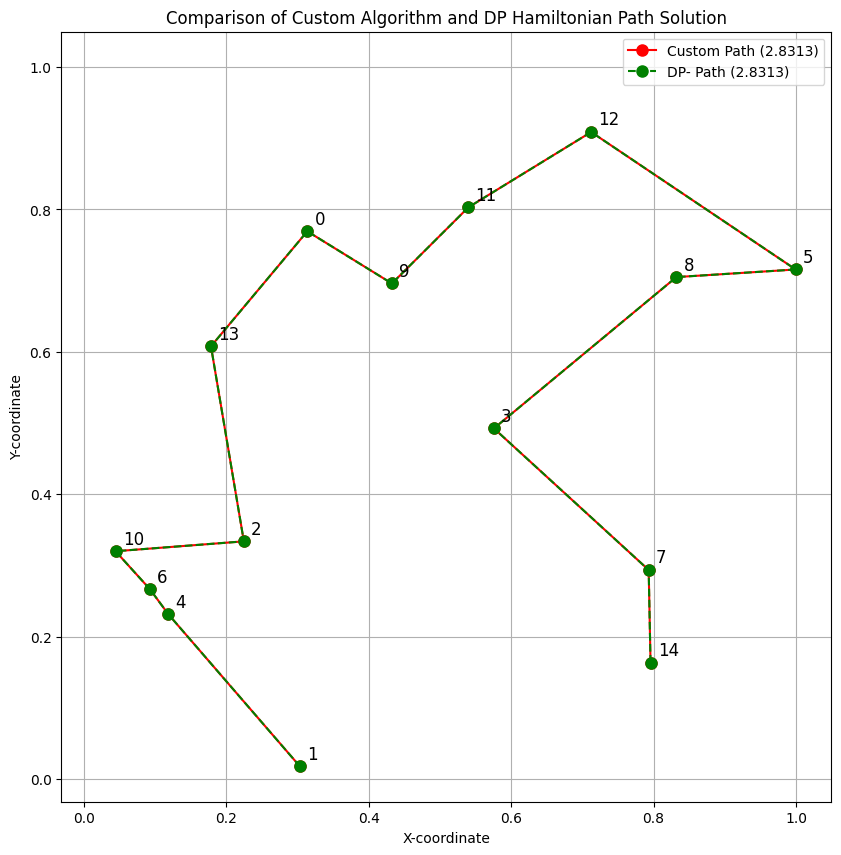

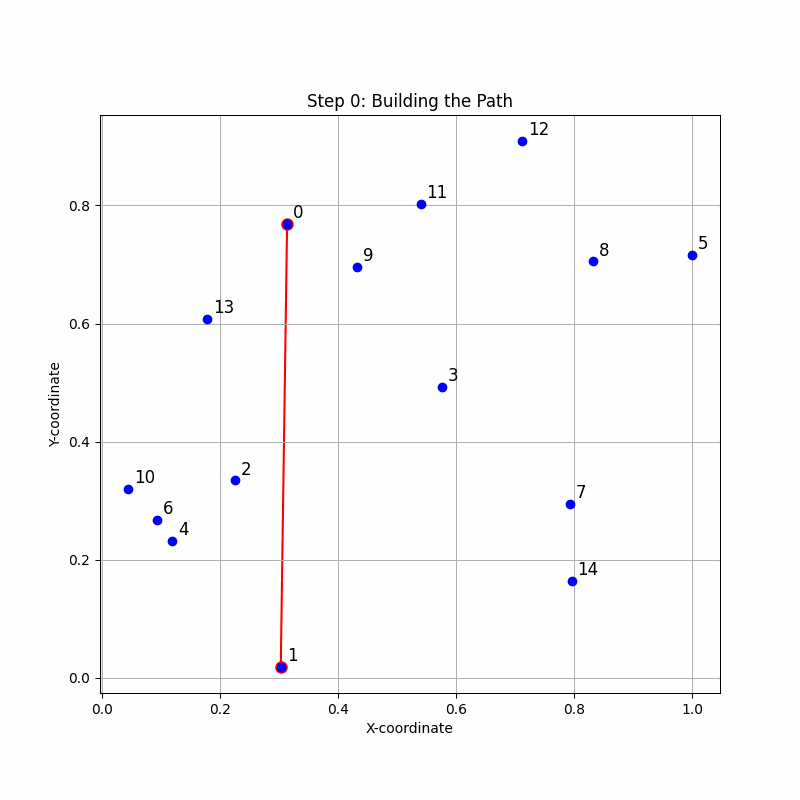

([14, 7, 3, 8, 5, 12, 11, 9, 0, 13, 2, 10, 6, 4, 1],
 np.float64(2.8313154991625518))

In [13]:
main_parallel_hamiltonian_path(n=15, seed=344)